![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importación de librerías
%matplotlib inline

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [ ]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

# Transformo el tipo de datos en reales para las columnas tipo bool
X = X.astype({col: int for col in X.select_dtypes(include='bool').columns})

In [ ]:
# Estadísticas descriptivas de la variable de respuesta (precio del automóvil)
y.describe()

,Price
count,10495.000000
mean,14538.403716
std,3922.420961
min,5002.000000
25%,11999.000000
50%,15000.000000
75%,16999.000000
max,32444.000000


In [ ]:
# Separación de datos en set de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [ ]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        self.feature_index = feature_index  # Índice de la característica para dividir
        self.threshold = threshold          # Umbral de división
        self.left = left                    # Subárbol izquierdo
        self.right = right                  # Subárbol derecho
        self.var_red = var_red              # Reducción de varianza de la división
        self.value = value                  # Valor de la hoja (media)

class DecisionTreeRegressor:
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self._build_tree(dataset)

    def _build_tree(self, dataset, depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        n_samples, n_features = X.shape

        if n_samples >= self.min_samples_split and depth <= self.max_depth:
            best_split = self._get_best_split(dataset, n_features)
            if best_split and best_split['var_red'] > 0:
                left = self._build_tree(best_split['left'], depth + 1)
                right = self._build_tree(best_split['right'], depth + 1)
                return Node(best_split['feature'], best_split['threshold'], left, right, best_split['var_red'])

        return Node(value=np.mean(Y))

    def _get_best_split(self, dataset, n_features):
        best = {}
        max_var_red = -np.inf
        for feature in range(n_features):
            thresholds = np.unique(dataset[:, feature])
            for threshold in thresholds:
                left, right = self._split(dataset, feature, threshold)
                if len(left) and len(right):
                    y, y_left, y_right = dataset[:, -1], left[:, -1], right[:, -1]
                    var_red = self._variance_reduction(y, y_left, y_right)
                    if var_red > max_var_red:
                        best = {
                            'feature': feature,
                            'threshold': threshold,
                            'left': left,
                            'right': right,
                            'var_red': var_red
                        }
                        max_var_red = var_red
        return best

    def _split(self, dataset, feature, threshold):
        left = dataset[dataset[:, feature] <= threshold]
        right = dataset[dataset[:, feature] > threshold]
        return left, right

    def _variance_reduction(self, parent, left, right):
        w_left, w_right = len(left) / len(parent), len(right) / len(parent)
        return np.var(parent) - (w_left * np.var(left) + w_right * np.var(right))

    def _predict(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._predict(x, node.left)
        else:
            return self._predict(x, node.right)

    def predict(self, X):
        return [self._predict(x, self.root) for x in X]

    def print_tree(self, node=None, indent="  "):
        node = node or self.root
        if node.value is not None:
            print(f"{indent}Valor hoja: {node.value:.4f}")
        else:
            print(f"{indent}X[{node.feature_index}] <= {node.threshold:.4f}  (VarRed: {node.var_red:.4f})")
            print(f"{indent}├─ Izquierda:")
            self.print_tree(node.left, indent + "  ")
            print(f"{indent}└─ Derecha:")
            self.print_tree(node.right, indent + "  ")

In [ ]:
# Entreno el modelo

y_train_s = y_train.values.reshape(-1,1)
regressor = DecisionTreeRegressor(min_samples_split=10, max_depth=9)
regressor.fit(X_train, y_train_s)

y_pred = regressor.predict(X_test.to_numpy())
np.sqrt(mean_squared_error(y_test, y_pred))

# Calcular RMSE y MAE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nRMSE en el set de test: {rmse:.4f}")
print(f"MAE en el set de test: {mae:.4f}")


RMSE en el set de test: 1687.7394
MAE en el set de test: 1219.1276


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Semilla para reproducibilidad
np.random.seed(123)
n_samples = X.shape[0]
n_B = 10

# Creamos 10 muestras bootstrap (índices)
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(n_B)]

# DataFrame para guardar predicciones
y_pred = pd.DataFrame(index=X_test.index, columns=range(n_B))

# Entrenamos un árbol por muestra
for i, sample in enumerate(samples):
    X_b = X.iloc[sample, :]
    y_b = y.iloc[sample]
    model = DecisionTreeRegressor(max_depth=None, random_state=123)
    model.fit(X_b, y_b)
    y_pred.iloc[:, i] = model.predict(X_test)

# Evaluación individual
for i in range(n_B):
    error = np.sqrt(mean_squared_error(y_test, y_pred.iloc[:, i]))
    print(f'Árbol {i} - RMSE: {error:.4f}')

# Predicción promedio del ensemble
y_pred_mean = y_pred.mean(axis=1)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_mean))
print(f'\nBagging (promedio de {n_B} árboles) - RMSE: {ensemble_rmse:.4f}')

Árbol 0 - RMSE: 1360.3012
Árbol 1 - RMSE: 1302.5504
Árbol 2 - RMSE: 1299.2192
Árbol 3 - RMSE: 1303.1262
Árbol 4 - RMSE: 1290.9847
Árbol 5 - RMSE: 1295.9533
Árbol 6 - RMSE: 1309.9602
Árbol 7 - RMSE: 1348.4104
Árbol 8 - RMSE: 1317.4426
Árbol 9 - RMSE: 1330.1407

Bagging (promedio de 10 árboles) - RMSE: 769.1837


El desempeño del modelo con bagging es significativamente mejor, pues el RMSE de los arboles individuales va desde 1297.5757 hasta 1360.3012, pero al utilizar el modelo con bagging se obtiene un RMSE de 768.2936, es decir que se reduce el RMSE del arbol 0 casi a la mitad.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [ ]:
# Determinar el valor de log(n_features)
n_features = X.shape[1]
max_features = int(np.log2(n_features))

# Instanciar el modelo Bagging con 10 árboles y max_features = log(n_features)
bagging_reg = BaggingRegressor(
    estimator = DecisionTreeRegressor(),
    n_estimators=10,
    max_features=max_features,
    random_state=0
)

# Revisar desempeño del modelo usando validación cruzada
from sklearn.model_selection import cross_val_score
pd.Series(cross_val_score(bagging_reg, X, y, cv=10)).describe()

,0
count,10.000000
mean,0.736122
std,0.012220
min,0.719605
25%,0.725936
50%,0.736888
75%,0.745107
max,0.756199


In [ ]:
# Entrenar el modelo
bagging_reg.fit(X_train, y_train)

# Realizar predicciones
predicciones_bagging = bagging_reg.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE)
import numpy as np
MSE_bagging = np.average(np.square(predicciones_bagging - y_test))
print('MSE del modelo bagging: ' + str(MSE_bagging))
print()

# Calcular la raíz del Error Cuadrático Medio (RMSE)
RMSE_bagging = np.sqrt(MSE_bagging)
print('RMSE del modelo bagging: ' + str(RMSE_bagging))
print()

# Calcular MAPE
MAPE_bagging = (np.average(abs((predicciones_bagging - y_test))/abs(predicciones_bagging)))*100
print(f"MAPE del modelo bagging: {MAPE_bagging:.2f}%")

MSE del modelo bagging: 4030750.9352369946

RMSE del modelo bagging: 2007.6730150193769

MAPE del modelo bagging: 11.29%


**Análisis del desempeño del modelo:**

* En la validación cruzada, el modelo Bagging con 10 árboles de regresión, muestra un desempeño moderado con una media de score de 0.7361 y una baja desviación estándar de 0.0122, lo que indica estabilidad en las particiones del conjunto de datos (rango de 0.7196 a 0.7562).

* El modelo Random Forest muestra un nivel de precisión moderado, con un RMSE de 2,007.67, indicando que el error promedio de las predicciones es aproximadamente 2,007 unidades monetarias, lo cual es aceptable dado el rango de precios de los automóviles (de 5,002 a 32,444 y un promedio de 14,538.40). Además, un MAPE de 11.29% indica que, en promedio, las predicciones difieren en un 11.29% del valor real.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [ ]:
# Implementar modelo Random Forest para regresión
rf_reg = RandomForestRegressor(random_state=0)

# Revisar desempeño del modelo usando validación cruzada
pd.Series(cross_val_score(rf_reg, X, y, cv=10)).describe()

,0
count,10.000000
mean,0.801627
std,0.011419
min,0.781813
25%,0.796039
50%,0.802777
75%,0.806592
max,0.818280


In [ ]:
# Entrenar el modelo
rf_reg.fit(X_train, y_train)

# Realizar predicciones
prediccionesRF = rf_reg.predict(X_test)

# Calcular el Error Cuadrático Medio (MSE)
MSE_RF = np.average(np.square(prediccionesRF - y_test))
print('MSE del modelo Random Forest: ' + str(MSE_RF))
print()

# Calcular la raíz del Error Cuadrático Medio (RMSE)
RMSE_RF = np.sqrt(MSE_RF)
print('RMSE del modelo Random Forest: ' + str(RMSE_RF))
print()

# Calcular MAPE
MAPE_RF = (np.average(abs((prediccionesRF - y_test))/abs(prediccionesRF)))*100
print(f"MAPE del modelo Random Forest: {MAPE_RF:.2f}%")
print()

# Obtener la importancia de las variables
importancia_variables = rf_reg.feature_importances_
for nombre, importancia in zip(X.columns, importancia_variables):
    print(f"{nombre}: {importancia}")

MSE del modelo Random Forest: 3101046.819865033

RMSE del modelo Random Forest: 1760.9789379390752

MAPE del modelo Random Forest: 9.48%

Year: 0.7097674670400855
Mileage: 0.2505540699025637
M_Camry: 0.007735869405420678
M_Camry4dr: 0.0011192888696469785
M_CamryBase: 0.00044053630746319124
M_CamryL: 0.001230665110549096
M_CamryLE: 0.008542944530407064
M_CamrySE: 0.004724004609617903
M_CamryXLE: 0.015885154224245863


**Análisis sobre el desempeño del modelo:**

* En la validación cruzada de 10 pliegues, el modelo Random Forest para regresión demuestra una capacidad predictiva sólida y consistente con una media de score de 0.8016 y una baja desviación estándar de 0.0114. A pesar de ligeras variaciones entre particiones (rango de 0.7818 a 0.8182), el modelo generaliza bien, mostrando estabilidad sin evidencias de sobreajuste ni subajuste.

* El modelo Random Forest demuestra un desempeño sólido y razonable, con un RMSE de 1,760.98, indicando que el error promedio de las predicciones es aproximadamente 1,761 unidades monetarias, lo cual es aceptable dado el rango de precios del conjunto de datos (de 5,002 a 32,444 y un promedio de 14,538.40). Además, con un MAPE de 9.48%, el modelo muestra un error relativo promedio bajo, confirmando que las predicciones difieren en menos del 10% en relación con los valores reales. Esto refleja que el modelo captura bien las relaciones entre las variables y ofrece un buen equilibrio entre precisión y generalización.

* La variable más influyente en el precio de los automóviles es el año del vehículo (0.7098), ya que los modelos más recientes suelen ser más valiosos, seguida por el kilometraje (0.2506), que afecta negativamente el precio a medida que aumenta. En contraste, las variables categóricas relacionadas con el modelo del automóvil, como M_CamryLE (0.0085) o M_CamryXLE (0.0159), tienen una influencia menor, lo que sugiere que su impacto en el precio es menos significativo en comparación con el año y el kilometraje.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### Calibración de n_estimators

In [ ]:
# Celda 5

# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 310, 10)

# Definición de lista para almacenar el R² promedio para cada valor de n_estimators
r2_scores = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    reg = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    r2_scores.append(cross_val_score(reg, X_train, y_train, cv=5, scoring='r2').mean())

Text(0, 0.5, 'r2')

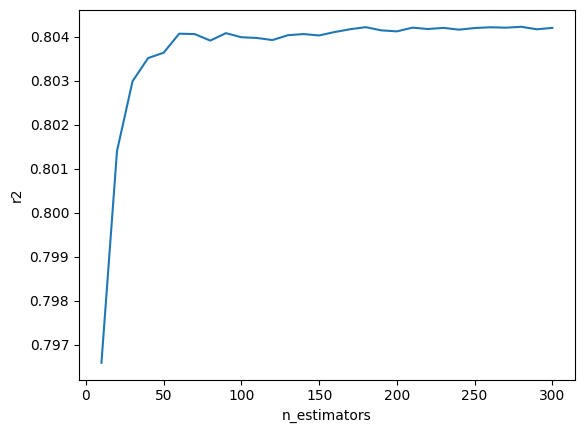

In [ ]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
import matplotlib.pyplot as plt

plt.plot(estimator_range, r2_scores)
plt.xlabel('n_estimators')
plt.ylabel('r2')

### Calibracióm max_features

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X.columns) + 1)

# Definición de lista para almacenar la puntuación R² promedio para cada valor de max_features
r2_scores = []

# Uso de un 10-fold cross-validation para cada valor de max_features
for feature in feature_range:
    reg = RandomForestRegressor(n_estimators=180, max_features=feature, random_state=1, n_jobs=-1)
    r2_scores.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

Text(0, 0.5, 'r2')

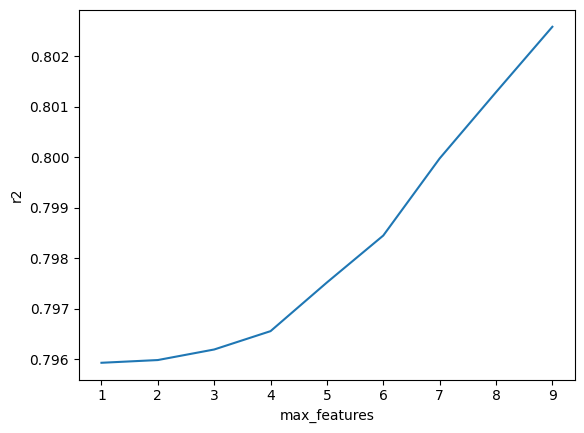

In [ ]:
plt.plot(feature_range, r2_scores)
plt.xlabel('max_features')
plt.ylabel('r2')

### Calibracióm max_depth

In [ ]:
# Creación de lista de valores para iterar sobre diferentes valores de max_depth
max_depth =  [3, 5, 7, 9, 11, 13, 15]

# Definición de lista para almacenar la puntuación R² promedio para cada valor de max_depth
r2_scores = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in max_depth:
    reg = RandomForestRegressor(n_estimators=180, max_features= 9, max_depth=depth, random_state=1, n_jobs=-1)
    r2_scores.append(cross_val_score(reg, X, y, cv=5, scoring='r2').mean())

Text(0, 0.5, 'r2')

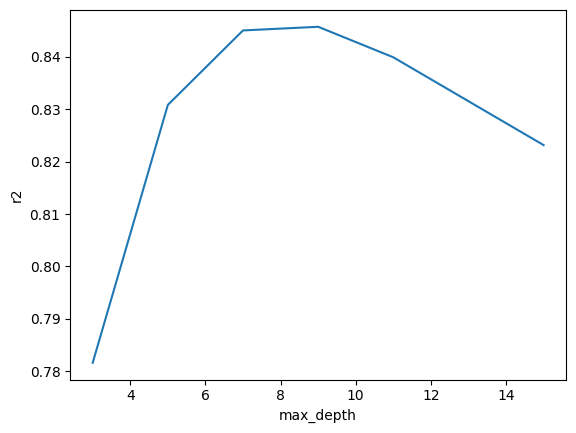

In [ ]:
plt.plot(max_depth, r2_scores)
plt.xlabel('max_depth')
plt.ylabel('r2')

### Implementación de un Random Forest con los mejores parámetros

In [ ]:
# Definición del modelo con los parámetros max_features=9, n_estimators=180 y n_max_depth = 9
reg_f =  RandomForestRegressor(n_estimators=180, max_features=9, max_depth=9, random_state=1, n_jobs=-1)
# Realizar predicciones
reg_f.fit(X_train, y_train)
predict = reg_f.predict(X_test)
# Calcular el Error Cuadrático Medio (MSE)
import numpy as np
MSE = np.average(np.square(predict - y_test))
print('MSE del modelo Random Forest: ' + str(MSE))
print()

# Calcular la raíz del Error Cuadrático Medio (RMSE)
RMSE = np.sqrt(MSE)
print('RMSE del modelo Random Forest: ' + str(RMSE))
print()

# Calcular MAPE
MAPE = (np.average(abs((predict - y_test))/abs(predict)))*100
print(f"MAPE del modelo Random Forest: {MAPE:.3f}%")
print()

MSE del modelo Random Forest: 2463141.0626700674

RMSE del modelo Random Forest: 1569.439728906487

MAPE del modelo Random Forest: 8.380%



In [ ]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':X.columns, 'importance':reg_f.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000263
3,M_Camry4dr,0.000492
5,M_CamryL,0.000612
7,M_CamrySE,0.003551
2,M_Camry,0.007937
6,M_CamryLE,0.008392
8,M_CamryXLE,0.017057
1,Mileage,0.176122
0,Year,0.785576


### **Resultados:**

**RMSE:** Aproximadamente 1569, lo que significa que, en promedio, las predicciones se desvían del precio real en unos 1569 unidades monetarias.

**MAPE:** Con un 8.38%, en promedio las predicciones están a menos del 10% del precio real, lo cual es bastante aceptable, especialmente si consideramos que el precio promedio es de alrededor de 14.538.

**CV:** Se utilizaron 5 folds para calibrar cada estimador.

**Importancia de variables:** La variable más influyente en el precio de los automóviles es el año del vehículo (0.7855), ya que los modelos más recientes suelen ser más valiosos, seguida por el kilometraje (0.1761), que afecta negativamente el precio a medida que aumenta.

**n_estimators:**
- Aumentar el número de árboles suele reducir la varianza y estabilizar las predicciones, lo que mejora el desempeño hasta cierto punto.

**max_depth:**
- Un valor muy alto (o sin límite) permite que los árboles aprendan detalles muy específicos, pudiendo llevar a un sobreajuste y a una mala generalización en datos nuevos.
- Un valor demasiado bajo limita la capacidad del modelo para capturar la complejidad del problema, causando subajuste.

**max_features:**
- Cuando se configura un valor bajo para max_features, en cada división de cada árbol se selecciona solo un pequeño subconjunto de todas las variables disponibles. Esto hace que los árboles sean más diferentes entre sí, ya que cada uno se enfoca en distintas combinaciones de variables. Esa diversidad entre árboles reduce la probabilidad de que todos cometan el mismo error, lo que ayuda a que el modelo en conjunto generalice mejor a datos nuevos.
- Si se reduce demasiado, cada árbol podría disponer de información insuficiente para realizar buenas divisiones, afectando negativamente el desempeño.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
# Se instala XGBRegressor debido a que es un problema de regresión.
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
reg = XGBRegressor()
reg

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Entrenamiento
reg.fit(X_train, y_train)
# Evaluación
y_pred = reg.predict(X_test)

# Metricas desempeño regresión
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print("RMSE:", rmse)
print(f"R2: {r2}")

MSE: 2576781.0
RMSE: 1605.2354967418332
R2: 0.8315404653549194


In [ ]:
y.mean()

np.float64(14538.403716055265)

#### **Resultados:**

El modelo muestra un desempeño prometedor en la predicción del precio de automóviles, de acuerdo a lo siguiente:

- **RMSE:** Con un RMSE de aproximadamente 1,605, el error medio en las predicciones representa alrededor del 11% del precio promedio (14538). Esto indica que, en promedio, las predicciones del modelo se desvían del valor real en un porcentaje que puede ser aceptable dependiendo del contexto del mercado.

- **R²:** El coeficiente de determinación de 0.8315 indica que el modelo es capaz de explicar alrededor del 83.15% de la variación en los precios de los automóviles. Esto sugiere que el modelo captura gran parte de la información relevante para la predicción.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [ ]:
# Punto 7 - Calibración de parámetros XGBoost

# Importar librerías necesarias para el modelo XGBoost
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Definir el modelo básico para hacer la calibración
xgb = XGBRegressor(random_state=42)

# Parámetros para ajustar
params = {
    'learning_rate': [0.01, 0.1, 0.2],
    'gamma': [0, 0.5, 1],
    'colsample_bytree': [0.5, 0.7, 1]
}

# Usar GridSearchCV para buscar los mejores parámetros en los datos de entrenamiento
xgb_grid = GridSearchCV(xgb, params, scoring='neg_mean_squared_error', cv=3)

# Entrenar modelo con el grid search en datos de entrenamiento ya definidos
xgb_grid.fit(X_train, y_train)

# Tomar el mejor modelo encontrado
xgb_mejor = xgb_grid.best_estimator_

# Hacer predicciones con el mejor modelo en los datos de prueba
predicciones = xgb_mejor.predict(X_test)

# Evaluar rendimiento del modelo calibrado con RMSE y R²
rmse_calibrado = np.sqrt(mean_squared_error(y_test, predicciones))
r2_calibrado = r2_score(y_test, predicciones)

# Mostrar resultados
print("Mejores parámetros:", xgb_grid.best_params_)
print(f"RMSE después de ajustar parámetros: {rmse_calibrado:.2f}")
print(f"R² después de ajustar parámetros: {r2_calibrado:.4f}")



Mejores parámetros: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.1}
RMSE después de ajustar parámetros: 1547.96
R² después de ajustar parámetros: 0.8433


**Desempeño del modelo XGBoost calibrado:**

Después de ajustar los parámetros del modelo XGBoost, se obtuvieron los siguientes resultados:

RMSE: 1547.96

R²: 0.8433

Mejores parámetros:

learning_rate = 0.1

gamma = 0

colsample_bytree = 0.5

Estos valores muestran que el modelo calibrado tiene un buen desempeño. El RMSE nos dice que, en promedio, el modelo se equivoca por alrededor de 1548 unidades en la predicción del precio de los autos, lo cual es aceptable si lo comparamos con el promedio de precios en el dataset. Además, el valor de R² indica que el modelo logra explicar aproximadamente el 84.33% de la variabilidad en los precios. Esto muestra que el modelo es sólido y hace predicciones acertadas.

**¿Cómo afectan estos parámetros al modelo?**

learning_rate = 0.1 En este caso, 0.1 es un valor equilibrado que permite al modelo aprender bien sin correr el riesgo de sobreajustarse.

gamma = 0 Este parámetro define la ganancia mínima que se necesita para hacer una partición en un nodo del árbol. Al estar en cero, el modelo es más flexible y permite más divisiones.

colsample_bytree = 0.5 Este valor indica que el modelo toma solo el 50% de las variables disponibles para construir cada árbol. Esto introduce diversidad entre los árboles y ayuda a reducir el riesgo de sobreajuste y permitió mejorar la generalización del modelo.

En conclusión, el modelo calibrado mejora frente al modelo base, hace predicciones más precisas y se adapta mejor a los datos. La combinación de estos parámetros logró un buen balance entre la precisión y la generalización.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

**Comparación y análisis de resultados**

A continuación se comparan los resultados obtenidos con los diferentes modelos aplicados en este taller. Se consideraron las métricas de error (RMSE) y la capacidad explicativa (R² o MAPE) para evaluar el desempeño.

| Modelo                         | RMSE      | R² / MAPE     |
|-------------------------------|-----------|---------------|
| Árbol de decisión manual      | 1687.74   | —             |
| Bagging manual (promedio)     | **769.18**| —             |
| Bagging con librería          | 2007.67   | MAPE: 11.29%  |
| Random Forest (básico)        | 1760.98   | MAPE: 9.48%   |
| Random Forest (calibrado)     | 1569.44   | MAPE: 8.38%   |
| XGBoost (básico)              | 1605.24   | R²: 0.8315    |
| XGBoost (calibrado)           | **1547.96**| **R²: 0.8433** |

**Análisis general:**

- El modelo con mejor desempeño fue XGBoost calibrado, con el RMSE más bajo entre los modelos finales y el mayor valor de R². Esto indica que este modelo hace predicciones más precisas y explica mejor la variabilidad del precio para este caso.

- El modelo con menor desempeño fue el Bagging con librería, con un RMSE más alto y el MAPE más elevado. A pesar de ser una técnica robusta, en este caso no logró buenos resultados, posiblemente por no estar calibrado o por su forma de muestreo.

- El Random Forest calibrado también mejoró mucho frente a su versión básica, lo que muestra la importancia del ajuste de hiperparámetros.

**Ventajas del mejor modelo (XGBoost calibrado):**

- Permite controlar con detalle cómo aprende el modelo.
- Puede manejar relaciones complejas entre las variables.
- Al calibrarlo, mejora mucho su precisión.

**Desventajas del modelo con menor desempeño (Bagging con librería):**

- Usa modelos base simples que, sin ajustes, pueden no captar bien los patrones.
- Tiende a sobreajustarse si no se controla bien la diversidad de los árboles.